# Parameter Selection for NMF

Now we look at the more advanced task of parameter selection for NMF topic modelling - namely, selecting a useful value for the number of topics *k*.

First, let's load the TF-IDF normalised document-term matrix and list of terms that we stored earlier using *Joblib*:

In [1]:
import joblib

(A, terms, snippets) = joblib.load("cenario2-tweets-tfidf.pkl")

print("Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]))

Loaded 32194 X 2230 document-term matrix


### Create the Topic Models

A common approach for parameter selection is to Measure and compare the topic coherence of models generated for different values of *k*.

We need to start by pre-specifying an initial range of "sensible" values:

In [2]:
kmin, kmax = 5, 20

Apply NMF for each of these values:

In [3]:
from sklearn import decomposition

topic_models = []

# try each value of k
for k in range(kmin, kmax + 1, 5):
    print("Applying NMF for k=%d ..." % k)
    # run NMF
    model = decomposition.NMF(init="nndsvd", n_components=k)
    W = model.fit_transform(A)
    H = model.components_
    # store for later
    topic_models.append((k, W, H))

Applying NMF for k=5 ...
Applying NMF for k=10 ...
Applying NMF for k=15 ...
Applying NMF for k=20 ...


### Build a Word Embedding

To select the number of topics, here we will use a *topic coherence* measure called TC-W2V. This measure relies on the use of a *word embedding* model constructed from our corpus. So in this step we will use the *Gensim* implementation of Word2Vec to build a Word2Vec model based on our collection of news articles.

**Note:** If you want to skip this step, a pre-built Word2Vec model for the sample dataset [is also provided here for download](http://erdos.ucd.ie/files/pydata/w2v-model.bin) (71MB).

We read the documents from the input file again:

In [4]:
import os.path

raw_documents = []

with open(os.path.join("../../././../../../data-pre-processing/2csv/cenario2_8M2021_tweets_pt.txt"), "r") as fin:
    for line in fin.readlines():
        raw_documents.append(line.strip().lower())

print("Read %d raw text documents" % len(raw_documents))

Read 32194 raw text documents


Read the custom stopword list:

In [5]:
custom_stop_words = []

with open("portuguese.txt", "r") as fin:
    for line in fin.readlines():
        custom_stop_words.append(line.strip().lower())

# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words))

Stopword list has 231 entries


First, we need to define a class that will generate documents in a form that can be consumed by Gensim's Word2Vec implementation:

In [6]:
import re


class TokenGenerator:
    def __init__(self, documents, stopwords):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile(r"(?u)\b\w\w+\b")

    def __iter__(self):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall(doc):
                if tok in self.stopwords:
                    tokens.append("<stopword>")
                elif len(tok) >= 2:
                    tokens.append(tok)
            yield tokens

Now build a Skipgram Word2Vec model from all documents in the input file using *Gensim*:

In [7]:
import gensim

In [8]:
docgen = TokenGenerator(raw_documents, custom_stop_words)

# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [9]:
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 2273 terms


Save for later use, so that we do not need to rebuild it:

In [10]:
w2v_model.save("cenario2_w2v-model.bin")

In [11]:
# To re-load this model, run
# w2v_model = gensim.models.Word2Vec.load("cenario1_w2v-model.bin")

### Selecting the Number of Topics

Once we have our Word2vec model, we can use it as part of our *topic coherence* approach to evaluate the different NMF topic models that we created previously. To do this, we will implement a simple version of the TC-W2V coherence measure.

We use the Word2vec model to calculate coherence scores for each of these models. We will define this coherence score as follows:

In [12]:
def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations(term_rankings[topic_index], 2):
            pair_scores.append(w2v_model.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

We also define a function to get the topic descriptor (i.e. list of top terms) for each topic:

In [13]:
import numpy as np


def get_descriptor(all_terms, H, topic_index, top):
    # reverse sort the values to sort the indices
    top_indices = np.argsort(H[topic_index, :])[::-1]
    
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    
    for term_index in top_indices[0:top]:
        top_terms.append(all_terms[term_index])
    
    return top_terms

Now process each of the models for different values of *k*:

# 5

In [14]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 5))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

K=05: Coherence=0.5797
K=10: Coherence=0.6060
K=15: Coherence=0.5933
K=20: Coherence=0.6121


/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


We can now use *matplotlib* to generate a line plot of these coherence scores, to help us select an appropriate value.

In [15]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

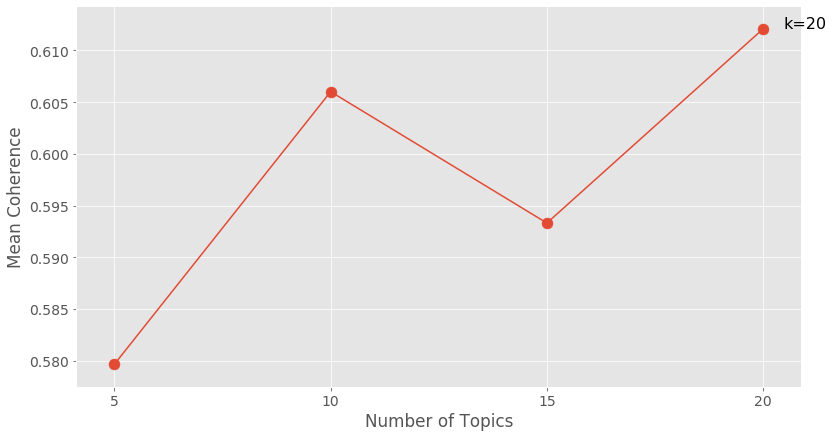

In [16]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

# 10

In [17]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 10))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

K=05: Coherence=0.5758
K=10: Coherence=0.5746
K=15: Coherence=0.5624
K=20: Coherence=0.6004


/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


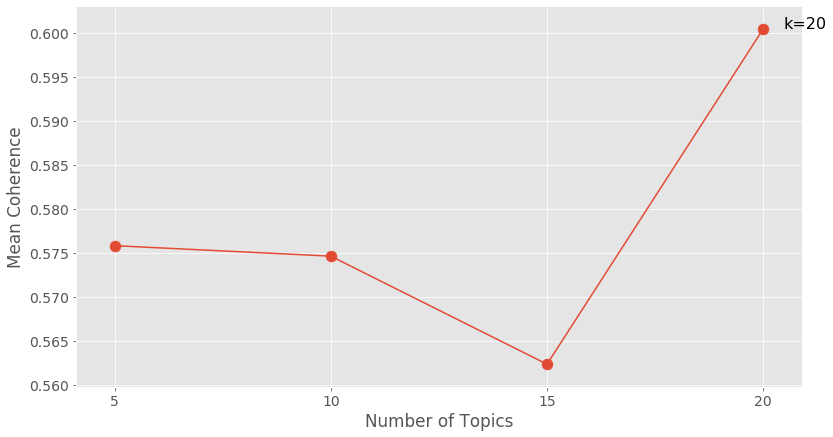

In [18]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

# 15 

In [19]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 15))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

K=05: Coherence=0.5309
K=10: Coherence=0.5515
K=15: Coherence=0.5644
K=20: Coherence=0.5795


/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


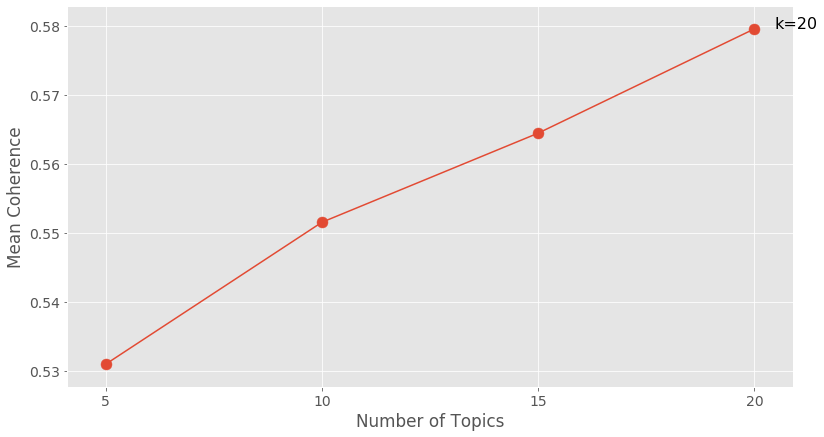

In [20]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

# 20

In [21]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 20))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


K=05: Coherence=0.5272
K=10: Coherence=0.5531
K=15: Coherence=0.5542
K=20: Coherence=0.5731


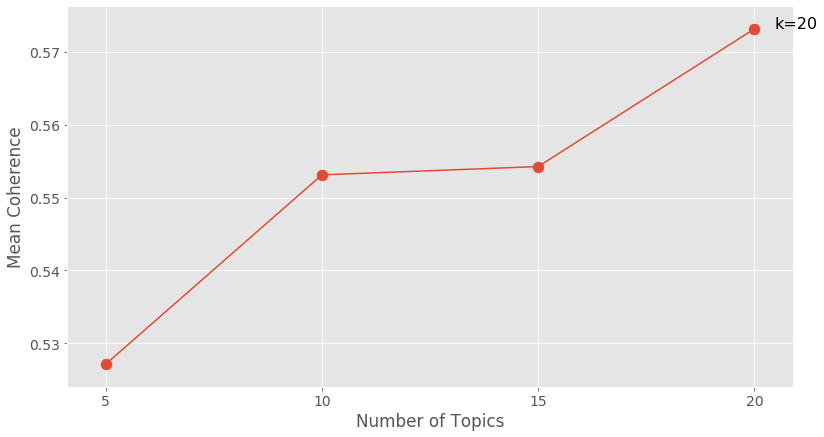

In [22]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

### Examine the Final  Model

The plot above suggests that the most appropriate value for the number of topics is *k=8*.

In [23]:
k = 5 # best_k

# get the model that we generated earlier.
W = topic_models[0][1]
H = topic_models[0][2]

Display the topic descriptors for this model:

In [24]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, dia, hoje, ser
Topic 02: mulheres, parabens, mundo, dia, luta
Topic 03: marco, dia, luta, lula, hoje
Topic 04: feliz, dia, guerreiras, incriveis, woman
Topic 05: amo, tanto, amor, demais, tudo


In [25]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, dia, hoje, ser, homenagem, especial, parabens, continuacao, presente
Topic 02: mulheres, parabens, mundo, dia, luta, hoje, dias, vida, respeito, incriveis
Topic 03: marco, dia, luta, lula, hoje, ano, data, respeito, dias, ainda
Topic 04: feliz, dia, guerreiras, incriveis, woman, vcs, god, deseja, dias, bom
Topic 05: amo, tanto, amor, demais, tudo, vida, deus, vcs, liam, video


In [26]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, dia, hoje, ser, homenagem, especial, parabens, continuacao, presente, via, sobre, mae, melhor, homem
Topic 02: mulheres, parabens, mundo, dia, luta, hoje, dias, vida, respeito, incriveis, especial, forca, direitos, ser, igualdade
Topic 03: marco, dia, luta, lula, hoje, ano, data, respeito, dias, ainda, sobre, flores, brasil, gente, feira
Topic 04: feliz, dia, guerreiras, incriveis, woman, vcs, god, deseja, dias, bom, maravilhosas, desejar, sempre, mulherada, instagram
Topic 05: amo, tanto, amor, demais, tudo, vida, deus, vcs, liam, video, aqui, ser, gente, mae, obrigada


In [27]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, dia, hoje, ser, homenagem, especial, parabens, continuacao, presente, via, sobre, mae, melhor, homem, lula, onde, brasil, quiser, lugar
Topic 02: mulheres, parabens, mundo, dia, luta, hoje, dias, vida, respeito, incriveis, especial, forca, direitos, ser, igualdade, guerreiras, sempre, fortes, aqui, homenagem
Topic 03: marco, dia, luta, lula, hoje, ano, data, respeito, dias, ainda, sobre, flores, brasil, gente, feira, ser, anos, apenas, vai, segunda
Topic 04: feliz, dia, guerreiras, incriveis, woman, vcs, god, deseja, dias, bom, maravilhosas, desejar, sempre, mulherada, instagram, lindas, fortes, amor, mulheres, seguidoras
Topic 05: amo, tanto, amor, demais, tudo, vida, deus, vcs, liam, video, aqui, ser, gente, mae, obrigada, linda, camila, sempre, cara, lindo


# 10

In [28]:
k = 10 # best_k

# get the model that we generated earlier.
W = topic_models[1][1]
H = topic_models[1][2]

In [29]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, dia, homenagem, continuacao
Topic 02: mulheres, mundo, dia, vida, luta
Topic 03: marco, dia, lula, ano, data
Topic 04: feliz, dia, guerreiras, dias, vcs
Topic 05: amo, tanto, amor, demais, vida
Topic 06: ser, mulher, mundo, vai, pode
Topic 07: parabens, guerreiras, dias, mundo, vcs
Topic 08: hoje, luta, dia, respeito, dias
Topic 09: woman, god, ariana, grande, deus
Topic 10: aqui, gente, tudo, video, bom


In [30]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, dia, homenagem, continuacao, especial, via, presente, mae, lula
Topic 02: mulheres, mundo, dia, vida, luta, incriveis, especial, homenagem, fortes, brasil
Topic 03: marco, dia, lula, ano, data, brasil, luta, feira, segunda, ainda
Topic 04: feliz, dia, guerreiras, dias, vcs, incriveis, bom, deseja, maravilhosas, sempre
Topic 05: amo, tanto, amor, demais, vida, liam, vcs, deus, tudo, video
Topic 06: ser, mulher, mundo, vai, pode, tudo, ter, vida, quiser, forte
Topic 07: parabens, guerreiras, dias, mundo, vcs, linda, amor, forca, especial, respeito
Topic 08: hoje, luta, dia, respeito, dias, sempre, igualdade, direitos, sobre, flores
Topic 09: woman, god, ariana, grande, deus, musica, carla, juliette, dizia, joao
Topic 10: aqui, gente, tudo, video, bom, sobre, linda, demais, bem, deus


In [31]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, dia, homenagem, continuacao, especial, via, presente, mae, lula, sobre, comemoracao, brasil, instagram, melhor
Topic 02: mulheres, mundo, dia, vida, luta, incriveis, especial, homenagem, fortes, brasil, homens, direitos, forca, dias, contra
Topic 03: marco, dia, lula, ano, data, brasil, luta, feira, segunda, ainda, abril, anos, pleno, sobre, flores
Topic 04: feliz, dia, guerreiras, dias, vcs, incriveis, bom, deseja, maravilhosas, sempre, desejar, amor, lindas, instagram, mulherada
Topic 05: amo, tanto, amor, demais, vida, liam, vcs, deus, tudo, video, obrigada, mae, camila, cena, musica
Topic 06: ser, mulher, mundo, vai, pode, tudo, ter, vida, quiser, forte, homem, orgulho, deve, nunca, sempre
Topic 07: parabens, guerreiras, dias, mundo, vcs, linda, amor, forca, especial, respeito, guerreira, fazem, merecem, boa, dia
Topic 08: hoje, luta, dia, respeito, dias, sempre, igualdade, direitos, sobre, flores, ainda, queremos, forca, data, ano
Topic 09: woman, 

In [32]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, dia, homenagem, continuacao, especial, via, presente, mae, lula, sobre, comemoracao, brasil, instagram, melhor, homem, onde, lugar, ontem, segunda
Topic 02: mulheres, mundo, dia, vida, luta, incriveis, especial, homenagem, fortes, brasil, homens, direitos, forca, dias, contra, trans, guerreiras, fazem, outras, maravilhosas
Topic 03: marco, dia, lula, ano, data, brasil, luta, feira, segunda, ainda, abril, anos, pleno, sobre, flores, apenas, respeito, homens, elegivel, dias
Topic 04: feliz, dia, guerreiras, dias, vcs, incriveis, bom, deseja, maravilhosas, sempre, desejar, amor, lindas, instagram, mulherada, respeito, fortes, mundo, seguidoras, desejamos
Topic 05: amo, tanto, amor, demais, vida, liam, vcs, deus, tudo, video, obrigada, mae, camila, cena, musica, amiga, lindo, linda, instagram, cara
Topic 06: ser, mulher, mundo, vai, pode, tudo, ter, vida, quiser, forte, homem, orgulho, deve, nunca, sempre, ainda, cada, forca, melhor, quero
Topic 07: paraben

# 15

In [33]:
k = 15 # best_k

# get the model that we generated earlier.
W = topic_models[2][1]
H = topic_models[2][2]

In [34]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, homenagem, continuacao, especial
Topic 02: mulheres, incriveis, especial, homenagem, fortes
Topic 03: marco, lula, data, brasil, ano
Topic 04: feliz, guerreiras, vcs, incriveis, sempre
Topic 05: amo, tanto, demais, vida, amor
Topic 06: ser, vai, mulher, pode, ter
Topic 07: parabens, guerreiras, vcs, linda, especial
Topic 08: hoje, sempre, especial, tudo, sobre
Topic 09: woman, god, ariana, grande, musica
Topic 10: aqui, tudo, bom, video, sobre
Topic 11: luta, vida, direitos, igualdade, contra
Topic 12: mundo, melhor, brasil, tudo, lugar
Topic 13: dia, bom, internacional, cada, comemorar
Topic 14: gente, deus, linda, amor, coisa
Topic 15: dias, respeito, flores, igualdade, queremos


In [35]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, homenagem, continuacao, especial, via, presente, mae, sobre, brasil
Topic 02: mulheres, incriveis, especial, homenagem, fortes, vida, homens, brasil, trans, maravilhosas
Topic 03: marco, lula, data, brasil, ano, feira, segunda, pleno, anos, abril
Topic 04: feliz, guerreiras, vcs, incriveis, sempre, deseja, maravilhosas, instagram, dia, desejar
Topic 05: amo, tanto, demais, vida, amor, liam, vcs, tudo, video, camila
Topic 06: ser, vai, mulher, pode, ter, tudo, deve, orgulho, forte, quiser
Topic 07: parabens, guerreiras, vcs, linda, especial, forca, guerreira, boa, fazem, mulherada
Topic 08: hoje, sempre, especial, tudo, sobre, ainda, forca, data, mae, vou
Topic 09: woman, god, ariana, grande, musica, carla, juliette, dizia, disse, joao
Topic 10: aqui, tudo, bom, video, sobre, bem, demais, vcs, vou, homenagem
Topic 11: luta, vida, direitos, igualdade, contra, sobre, sempre, violencia, ainda, data
Topic 12: mundo, melhor, brasil, tudo, lugar, incriveis, fo

In [36]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, homenagem, continuacao, especial, via, presente, mae, sobre, brasil, onde, lugar, instagram, quiser, lula
Topic 02: mulheres, incriveis, especial, homenagem, fortes, vida, homens, brasil, trans, maravilhosas, outras, fazem, guerreiras, lindas, historia
Topic 03: marco, lula, data, brasil, ano, feira, segunda, pleno, anos, abril, sobre, ainda, via, elegivel, vai
Topic 04: feliz, guerreiras, vcs, incriveis, sempre, deseja, maravilhosas, instagram, dia, desejar, mulher, lindas, mulherada, fortes, seguidoras
Topic 05: amo, tanto, demais, vida, amor, liam, vcs, tudo, video, camila, obrigada, musica, mae, amiga, cena
Topic 06: ser, vai, mulher, pode, ter, tudo, deve, orgulho, forte, quiser, sempre, nunca, homem, assim, quero
Topic 07: parabens, guerreiras, vcs, linda, especial, forca, guerreira, boa, fazem, mulherada, brazil, sempre, batalhadoras, meninas, obrigado
Topic 08: hoje, sempre, especial, tudo, sobre, ainda, forca, data, mae, vou, politico, porque, 

In [37]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, homenagem, continuacao, especial, via, presente, mae, sobre, brasil, onde, lugar, instagram, quiser, lula, homem, dilma, segunda, primeira, melhor
Topic 02: mulheres, incriveis, especial, homenagem, fortes, vida, homens, brasil, trans, maravilhosas, outras, fazem, guerreiras, lindas, historia, lutam, inspiram, pandemia, forca, trabalho
Topic 03: marco, lula, data, brasil, ano, feira, segunda, pleno, anos, abril, sobre, ainda, via, elegivel, vai, homenagem, apenas, presente, homens, melhor
Topic 04: feliz, guerreiras, vcs, incriveis, sempre, deseja, maravilhosas, instagram, dia, desejar, mulher, lindas, mulherada, fortes, seguidoras, nunca, foda, amor, desejamos, via
Topic 05: amo, tanto, demais, vida, amor, liam, vcs, tudo, video, camila, obrigada, musica, mae, amiga, cena, admiro, instagram, lindas, serio, foto
Topic 06: ser, vai, mulher, pode, ter, tudo, deve, orgulho, forte, quiser, sempre, nunca, homem, assim, quero, queria, cada, fazer, ainda, incr

# 20

In [38]:
k = 20 # best_k

# get the model that we generated earlier.
W = topic_models[3][1]
H = topic_models[3][2]

In [39]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, continuacao, especial, via
Topic 02: mulheres, incriveis, fortes, especial, homens
Topic 03: marco, lula, data, ano, feira
Topic 04: feliz, guerreiras, vcs, incriveis, deseja
Topic 05: amo, tanto, demais, liam, vcs
Topic 06: ser, mulher, pode, vai, ter
Topic 07: parabens, guerreiras, vcs, especial, forca
Topic 08: hoje, sempre, especial, data, forca
Topic 09: woman, god, ariana, grande, musica
Topic 10: aqui, bem, demais, vou, vcs
Topic 11: luta, direitos, igualdade, contra, violencia
Topic 12: mundo, melhor, lugar, incriveis, forca
Topic 13: dia, internacional, bom, cada, comemorar
Topic 14: gente, linda, coisa, ainda, olha
Topic 15: deus, amor, linda, abencoe, tanto
Topic 16: dias, respeito, flores, igualdade, queremos
Topic 17: homenagem, linda, mae, especial, maior
Topic 18: vida, amor, especial, mae, vacina
Topic 19: tudo, sempre, bom, faz, melhor
Topic 20: sobre, brasil, video, ciro, vai


In [40]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, continuacao, especial, via, presente, onde, lugar, quiser, mae
Topic 02: mulheres, incriveis, fortes, especial, homens, trans, maravilhosas, outras, guerreiras, lindas
Topic 03: marco, lula, data, ano, feira, segunda, anos, pleno, abril, apenas
Topic 04: feliz, guerreiras, vcs, incriveis, deseja, maravilhosas, instagram, desejar, dia, lindas
Topic 05: amo, tanto, demais, liam, vcs, video, amor, camila, obrigada, musica
Topic 06: ser, mulher, pode, vai, ter, deve, orgulho, quiser, forte, assim
Topic 07: parabens, guerreiras, vcs, especial, forca, linda, guerreira, boa, fazem, mulherada
Topic 08: hoje, sempre, especial, data, forca, politico, vou, mae, amanha, porque
Topic 09: woman, god, ariana, grande, musica, carla, juliette, dizia, joao, disse
Topic 10: aqui, bem, demais, vou, vcs, deixar, fica, olha, voltou, bom
Topic 11: luta, direitos, igualdade, contra, violencia, data, forca, diaria, resistencia, viva
Topic 12: mundo, melhor, lugar, incriveis, fo

In [41]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, continuacao, especial, via, presente, onde, lugar, quiser, mae, homem, instagram, segunda, guerreira, comemoracao
Topic 02: mulheres, incriveis, fortes, especial, homens, trans, maravilhosas, outras, guerreiras, lindas, fazem, lutam, inspiram, direitos, historia
Topic 03: marco, lula, data, ano, feira, segunda, anos, pleno, abril, apenas, presente, via, aniversario, elegivel, homens
Topic 04: feliz, guerreiras, vcs, incriveis, deseja, maravilhosas, instagram, desejar, dia, lindas, mulherada, seguidoras, fortes, nunca, mulher
Topic 05: amo, tanto, demais, liam, vcs, video, amor, camila, obrigada, musica, amiga, cena, instagram, admiro, mae
Topic 06: ser, mulher, pode, vai, ter, deve, orgulho, quiser, forte, assim, homem, quero, queria, cada, nunca
Topic 07: parabens, guerreiras, vcs, especial, forca, linda, guerreira, boa, fazem, mulherada, brazil, brasil, meninas, batalhadoras, maluf
Topic 08: hoje, sempre, especial, data, forca, politico, vou, mae, ama

In [42]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, continuacao, especial, via, presente, onde, lugar, quiser, mae, homem, instagram, segunda, guerreira, comemoracao, mensagem, pleno, data, feira, boa
Topic 02: mulheres, incriveis, fortes, especial, homens, trans, maravilhosas, outras, guerreiras, lindas, fazem, lutam, inspiram, direitos, historia, pandemia, trabalho, forca, viva, deseja
Topic 03: marco, lula, data, ano, feira, segunda, anos, pleno, abril, apenas, presente, via, aniversario, elegivel, homens, fevereiro, melhor, joao, mes, semana
Topic 04: feliz, guerreiras, vcs, incriveis, deseja, maravilhosas, instagram, desejar, dia, lindas, mulherada, seguidoras, fortes, nunca, mulher, foda, via, sempre, desejamos, desejando
Topic 05: amo, tanto, demais, liam, vcs, video, amor, camila, obrigada, musica, amiga, cena, instagram, admiro, mae, lindas, foto, serio, lindo, cara
Topic 06: ser, mulher, pode, vai, ter, deve, orgulho, quiser, forte, assim, homem, quero, queria, cada, nunca, incrivel, forca, hum